### 훈련 데이터 생성

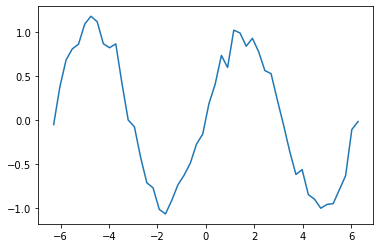

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sin_x = np.linspace(-2*np.pi, 2*np.pi)  # # -2π에서 2π까지
sin_y = np.sin(sin_x)  + 0.1*np.random.randn(len(sin_x))  # sin함수에 무작위로 노이즈 생성하기
plt.plot(sin_x, sin_y)
plt.show()

In [ ]:
# -- 훈련 데이터 생성  --
n_sample = len(sin_x)-n_time  # 샘플 수
input_data = np.zeros((n_sample, n_time, n_in))  # 입력
correct_data = np.zeros((n_sample, n_out))  # 정답
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 정답은 입력보다 한 시점 뒤

### simple_RNN

In [ ]:
import numpy as np
# import cupy as np  # GPU를 사용하면 주석 해제
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 10  # 시점 수
n_in = 1  # 입력층 뉴런 수
n_mid = 20  # 은닉층 뉴런 수
n_out = 1  # 출력층 뉴런 수

eta = 0.001  # 학습률
epochs = 101
batch_size = 8
interval = 5  # 경과 표시 간격

In [ ]:
# -- RNN층-- 
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
       # 파라미터 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.v = np.random.randn(n, n) / np.sqrt(n)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x, y_prev):  # y_prev: 이전 시점의 출력
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)  # 출력
    
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)

        # 각 기울기
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

In [ ]:
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 항등함수

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [ ]:
# -- 각 층의 초기화 --
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [ ]:
# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 RNN층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

    # 순전파 출력층
    output_layer.forward(y)

    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 역전파 RNN층
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev

    # 파라미터 갱신
    rnn_layer.update(eta)
    output_layer.update(eta)

In [ ]:
# -- 예측 --
def predict(x_mb):
    # 순전파 RNN층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_prev = y

    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

Epoch:1/101 Error:3.6284062057270425


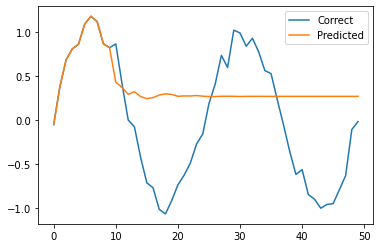

Epoch:6/101 Error:1.59065439663489


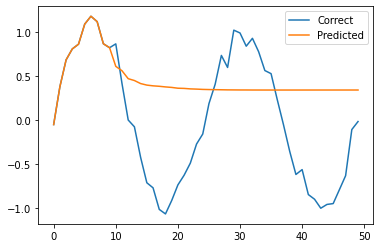

Epoch:11/101 Error:1.0795755766510031


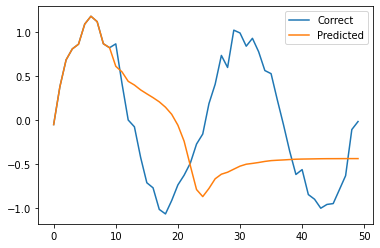

Epoch:16/101 Error:0.8718456425266534


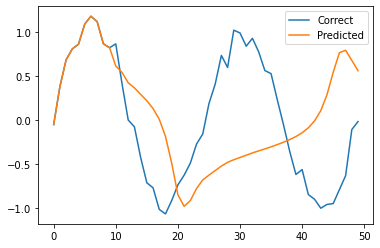

Epoch:21/101 Error:0.7695421257003346


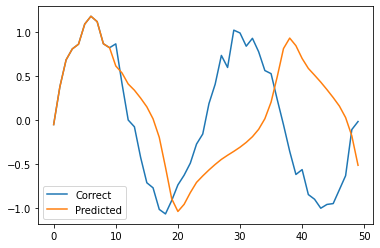

Epoch:26/101 Error:0.7073855748405586


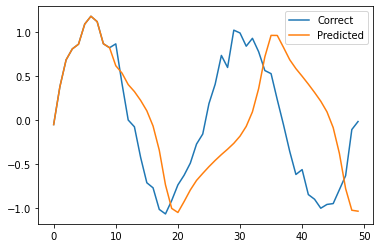

Epoch:31/101 Error:0.664231181219696


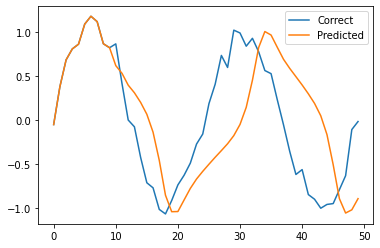

Epoch:36/101 Error:0.6304488181236931


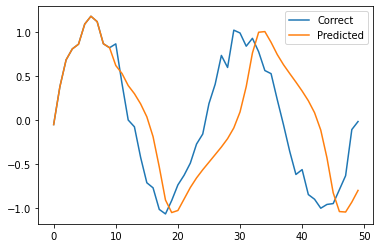

Epoch:41/101 Error:0.6026638177625121


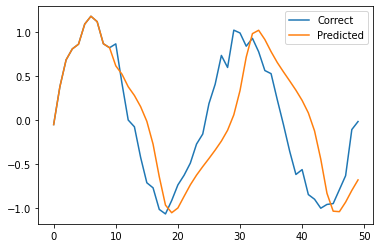

Epoch:46/101 Error:0.5790907182597461


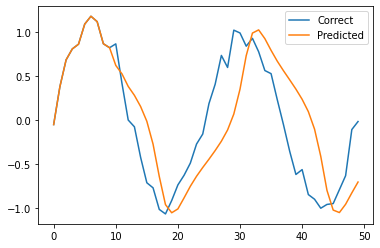

Epoch:51/101 Error:0.5586583690231597


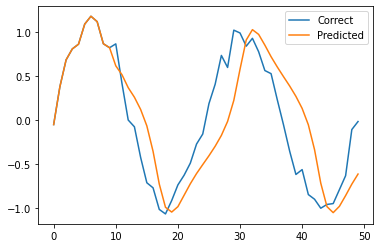

Epoch:56/101 Error:0.5406708191673469


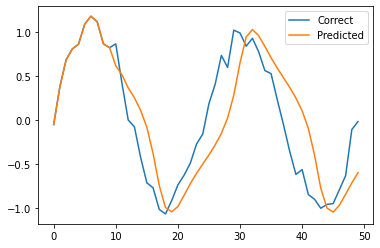

Epoch:61/101 Error:0.5250002273177581


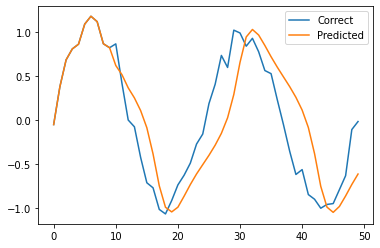

Epoch:66/101 Error:0.5107742658671652


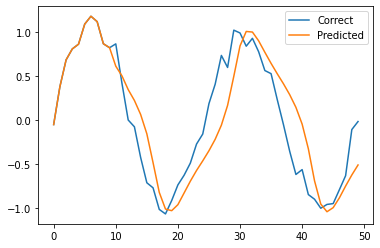

Epoch:71/101 Error:0.4983207667870996


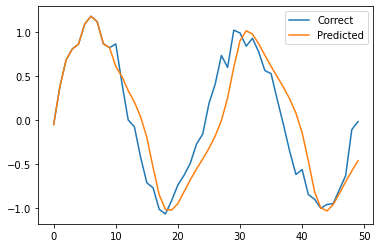

Epoch:76/101 Error:0.4867738659299612


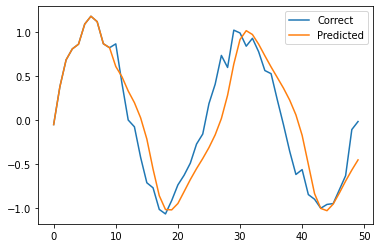

Epoch:81/101 Error:0.4764707745487027


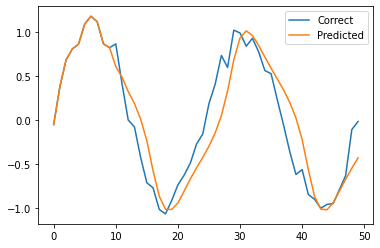

Epoch:86/101 Error:0.4666694630690022


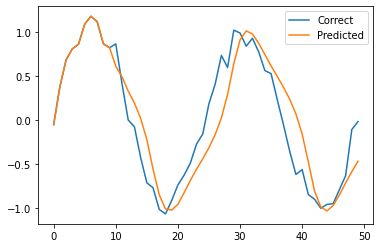

Epoch:91/101 Error:0.4583846142229262


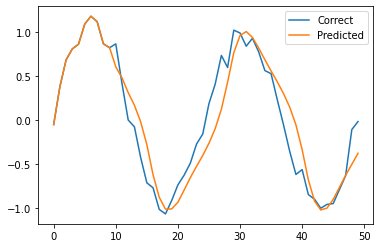

Epoch:96/101 Error:0.4497887912923598


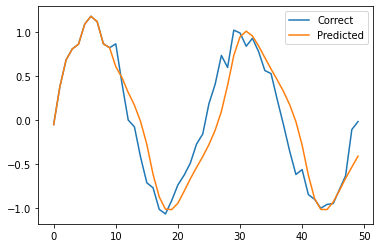

Epoch:101/101 Error:0.4422616187054844


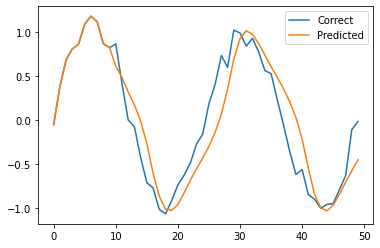

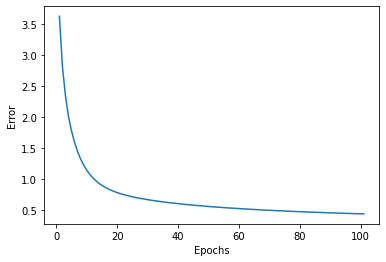

In [ ]:
# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 오차제곱합

error_record = []
n_batch = len(input_data) // batch_size  # # 1에포크당 배치 개수
for i in range(epochs):
        
    # -- 학습 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # 미니 배치 데이터 훈련
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # --오차 구하기 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 최초 입력
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # 출력을 predicted에 추가하기

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# simple_LSTM

In [ ]:
# -- 각 설정값 --
n_time = 10  # 시점의 수
n_in = 1  # 입력층 뉴런의 수
n_mid = 20  # 은닉층 뉴런의 수
n_out = 1  # 출력층 뉴런의 수


eta = 0.01  # 학습률
epochs = 101
batch_size = 8
interval = 10  # # 경과 표시 간격

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
# -- LSTM층 -- 
class LSTMLayer:
    def __init__(self, n_upper, n):
        # 각 파라미터의 초깃값
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n_upper)  # 자비에르 기반의 초깃값
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))

    def forward(self, x, y_prev, c_prev):  # y_prev, c_prev: 이전 시점의 출력과 기억 셀
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)

        a0 = sigmoid(u[0])  # 망각 게이트
        a1 = sigmoid(u[1])  # 입력 게이트
        a2 = np.tanh(u[2])  # 새로운 기억
        a3 = sigmoid(u[3])  # 출력 게이트
        self.gates = np.stack((a0, a1, a2, a3))
        #print(a3)

        self.c = a0*c_prev + a1*a2  # 기억 셀
        self.y = a3 * np.tanh(self.c)  # 출력
    
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):   
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + (grad_y*a3) * (1-tanh_c**2)

        # 각 delta
        delta_a0 = r * c_prev * a0 * (1-a0)
        delta_a1 = r * a2 * a1 * (1-a1)
        delta_a2 = r * a1 * (1 - a2**2)
        delta_a3 = grad_y * tanh_c * a3 * (1 - a3)

        deltas = np.stack((delta_a0, delta_a1, delta_a2, delta_a3))

        # 各 파라미터의 기울기
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)

        # x 기울기
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)

        # y_prev 기울기
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        # c_prev 기울기
        self.grad_c_prev = r * a0

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

In [ ]:
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 항등함수

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [ ]:
# -- 각 층의 초기화 --
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [ ]:
# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 LSTM층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)

        y = lstm_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        c = lstm_layer.c
        c_rnn[:, i+1, :] = c
        c_prev = c

        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 순전파 출력층
    output_layer.forward(y)

    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)

    # 순전파 LSTM층
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        c = c_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev

    # 파라미터 갱신
    lstm_layer.update(eta)
    output_layer.update(eta)

In [ ]:
# -- 예측 --
def predict(x_mb):
    # 순전파 LSTM층
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c

    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

Epoch:1/101 Error:5.855787563111283


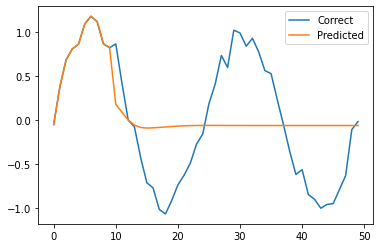

Epoch:11/101 Error:2.256055661881466


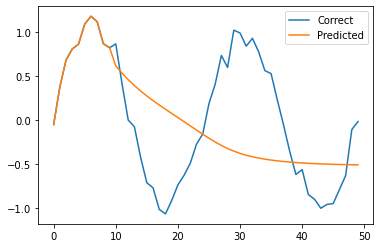

Epoch:21/101 Error:1.3890505830187838


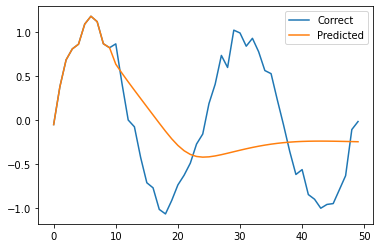

Epoch:31/101 Error:0.7794710622486081


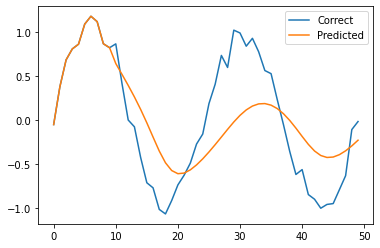

Epoch:41/101 Error:0.4819413782128481


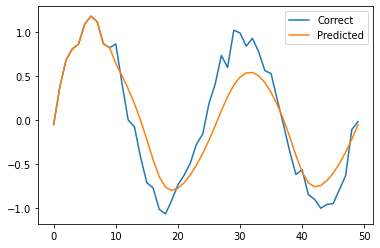

Epoch:51/101 Error:0.3836874806339776


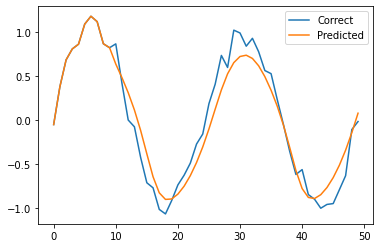

Epoch:61/101 Error:0.35635236305041484


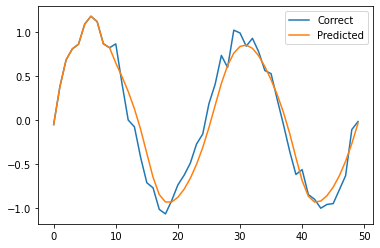

Epoch:71/101 Error:0.3462484271622966


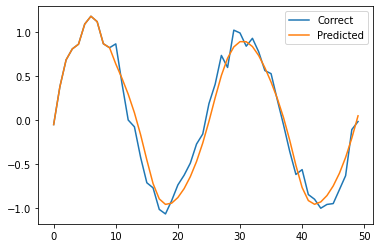

Epoch:81/101 Error:0.3415550394246268


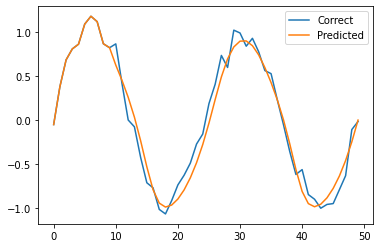

Epoch:91/101 Error:0.3368098161263393


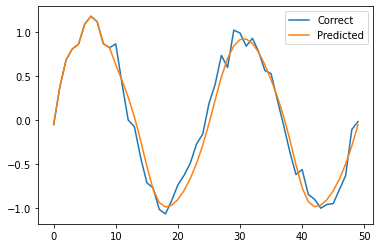

Epoch:101/101 Error:0.3326283594213906


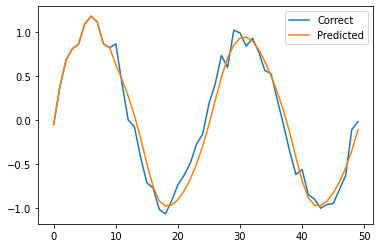

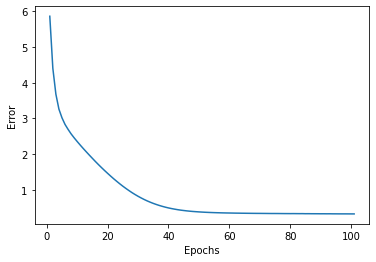

In [ ]:
# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 오차제곱합

error_record = []
n_batch = len(input_data) // batch_size  #  # 1에포크당 배치 개수
for i in range(epochs):
        
    # -- 학습 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  # 인덱스 임의 섞기
    for j in range(n_batch):
        
       # 미니 배치 구성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

   # -- 오차 계산 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

     # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 최초입력
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # # 출력을 predicted에 추가
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# simpe_GRU

In [ ]:
# -- 각 설정값 --
n_time = 10 # 시계열 데이터의 개수
n_in = 1 # 입력층의 뉴런 수
n_mid = 20 # 은닉층의 뉴런 수
n_out = 1 # 출력층의 뉴런 수

eta = 0.01 # 학습률
epochs = 101
batch_size = 8
interval = 10 # 학습 결과 표시 간격

def sigmoid(x):
    return 1/(1+np.exp(-x))

In [ ]:
# -- GRU층 -- 
class GRULayer:
    def __init__(self, n_upper, n):
        # 파라미터의 초깃값
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)  
        self.v = np.random.randn(3, n, n) / np.sqrt(n)

    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))  #  업데이트 게이트
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))  # 리셋 게이트
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2]))  # 새로운 기억
        self.gates = np.stack((a0, a1, a2))

        self.y = (1-a0)*y_prev + a0*a2  # 출력
    
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates

        # 새로운 기억
        delta_a2 = grad_y * a0 * (1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)

        # 업데이트 게이트
        delta_a0 = grad_y * (a2-y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)

        # 리겟 게이트
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s * y_prev * a1 * (1-a1)
        self.grad_w[1] += np.dot(x.T, delta_a1)
        self.grad_v[1] += np.dot(y_prev.T, delta_a1)

        # x의 기울기
        self.grad_x =  np.dot(delta_a0, self.w[0].T)
        + np.dot(delta_a1, self.w[1].T)
        + np.dot(delta_a2, self.w[2].T)

        # y_prev 기울기
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s + grad_y*(1-a0)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v

In [ ]:
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화(Xavier Initialization) 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # 항등함수

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)      
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [ ]:
# -- 각 층의 초기화 --
gru_layer = GRULayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [ ]:
# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 GRU층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)

        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        gates = gru_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 순전파 출력층
    output_layer.forward(y)

    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 역전파 출력층
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev

   # 파라미터 갱신
    gru_layer.update(eta)
    output_layer.update(eta)

In [ ]:
# -- 예측--
def predict(x_mb):
    # 순전파 GRU층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y

    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

Epoch:1/101 Error:6.364210987191141


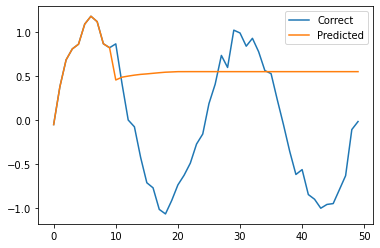

Epoch:11/101 Error:1.7222600455319919


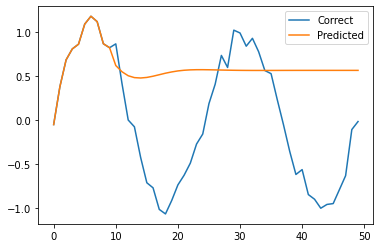

Epoch:21/101 Error:0.748260762946064


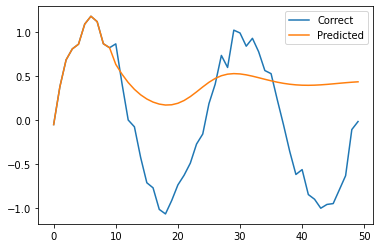

Epoch:31/101 Error:0.5650706217632042


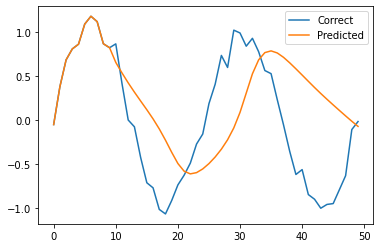

Epoch:41/101 Error:0.4986110117870257


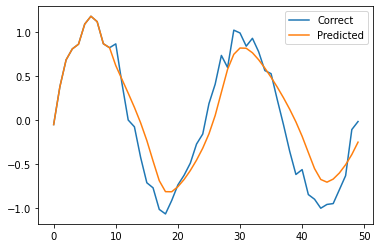

Epoch:51/101 Error:0.4697156480952249


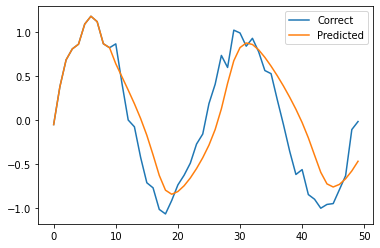

Epoch:61/101 Error:0.46823800291149575


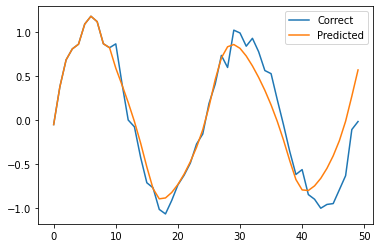

Epoch:71/101 Error:0.446245653294757


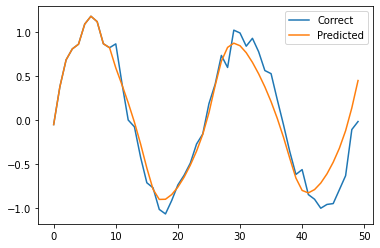

Epoch:81/101 Error:0.43042404255235617


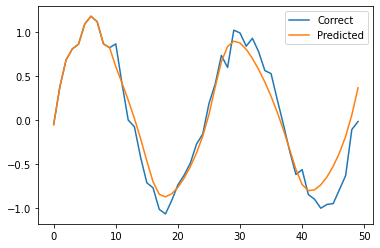

Epoch:91/101 Error:0.4189056685648623


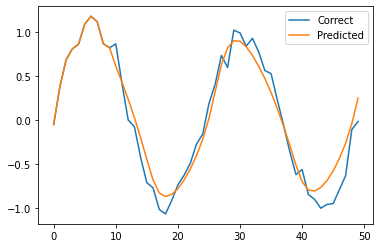

Epoch:101/101 Error:0.41761227777835574


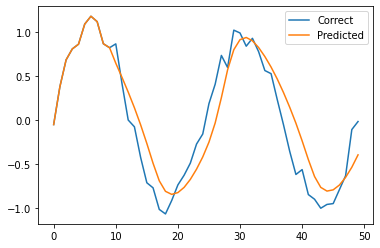

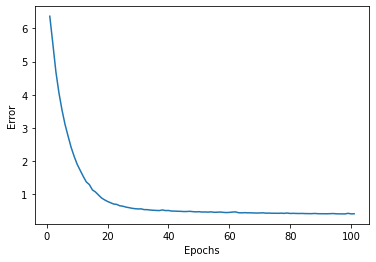

In [ ]:
# -- -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))  # 오차 제곱의 합

error_record = []
n_batch = len(input_data) // batch_size  # 1에포크당 배치 개수
for i in range(epochs):
        
    # -- 학습 -- 
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)  #  인덱스 뒤섞기(셔플하기)
    for j in range(n_batch):
        
        # # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)

    # -- 오차 계산 --
    error = get_error(input_data, correct_data)
    error_record.append(error)

    # -- 결과 확인 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

        predicted = input_data[0].reshape(-1).tolist() # 첫번째 입력
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))  # # 출력을 predicted에 추가

        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()